In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import timm
from tqdm import tqdm

/home/jessnou/python/hackaton/virtual_guide/hackaton-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Определим преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.ToTensor(),          # Преобразование в тензор
    transforms.Normalize(           # Нормализация
        mean=[0.485, 0.456, 0.406], # Средние значения для ImageNet
        std=[0.229, 0.224, 0.225]   # Стандартные отклонения для ImageNet
    )
])

# Загрузка данных для обучения и тестирования
train_dataset = datasets.ImageFolder(root='hermitage_images/train', transform=transform)
test_dataset = datasets.ImageFolder(root='hermitage_images/test', transform=transform)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:


# Замена последнего слоя
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, 9)

# Перемещение модели на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [4]:
# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

In [6]:
import os
import torch.optim as optim
import torch.nn as nn

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# Количество эпох
num_epochs = 10

save_dir = 'saved_models'

# Инициализация переменной для отслеживания минимальной ошибки
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Переключение модели в режим обучения
    running_loss = 0.0

    # Обучение
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loop.set_postfix(loss=running_loss/len(train_loader))

    # Вычисление ошибки на валидационной выборке
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}")

    # Сохранение модели, если ошибка уменьшилась
    if val_loss < best_loss:
        print(f"Validation loss improved from {best_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_vit.pth'))

Epoch 1/10, Train Loss: 2.464332024256388, Val Loss: 1.214888572692871
Validation loss improved from inf to 1.2149. Saving model...


Epoch 2/10, Train Loss: 1.3238847255706787, Val Loss: 0.5634453296661377
Validation loss improved from 1.2149 to 0.5634. Saving model...


Epoch 3/10, Train Loss: 0.6315886974334717, Val Loss: 0.3021184504032135
Validation loss improved from 0.5634 to 0.3021. Saving model...


Epoch 4/10, Train Loss: 0.3655244807402293, Val Loss: 0.18598219752311707
Validation loss improved from 0.3021 to 0.1860. Saving model...


Epoch 5/10, Train Loss: 0.2148070236047109, Val Loss: 0.1294793039560318
Validation loss improved from 0.1860 to 0.1295. Saving model...


Epoch 6/10, Train Loss: 0.11389868954817454, Val Loss: 0.09438565373420715
Validation loss improved from 0.1295 to 0.0944. Saving model...


Epoch 7/10, Train Loss: 0.07260772089163463, Val Loss: 0.07205046713352203
Validation loss improved from 0.0944 to 0.0721. Saving model...


Epoch 8/10, Train Loss: 0.05776233226060867, Val Loss: 0.05587000399827957
Validation loss improved from 0.0721 to 0.0559. Saving model...


Epoch 9/10, Train Loss: 0.04645498717824618, Val Loss: 0.04438699409365654
Validation loss improved from 0.0559 to 0.0444. Saving model...


Epoch 10/10, Train Loss: 0.036510745684305825, Val Loss: 0.03588145226240158
Validation loss improved from 0.0444 to 0.0359. Saving model...


In [7]:
correct = 0
total = 0

with torch.no_grad():  # Отключение вычисления градиентов
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 100.00%


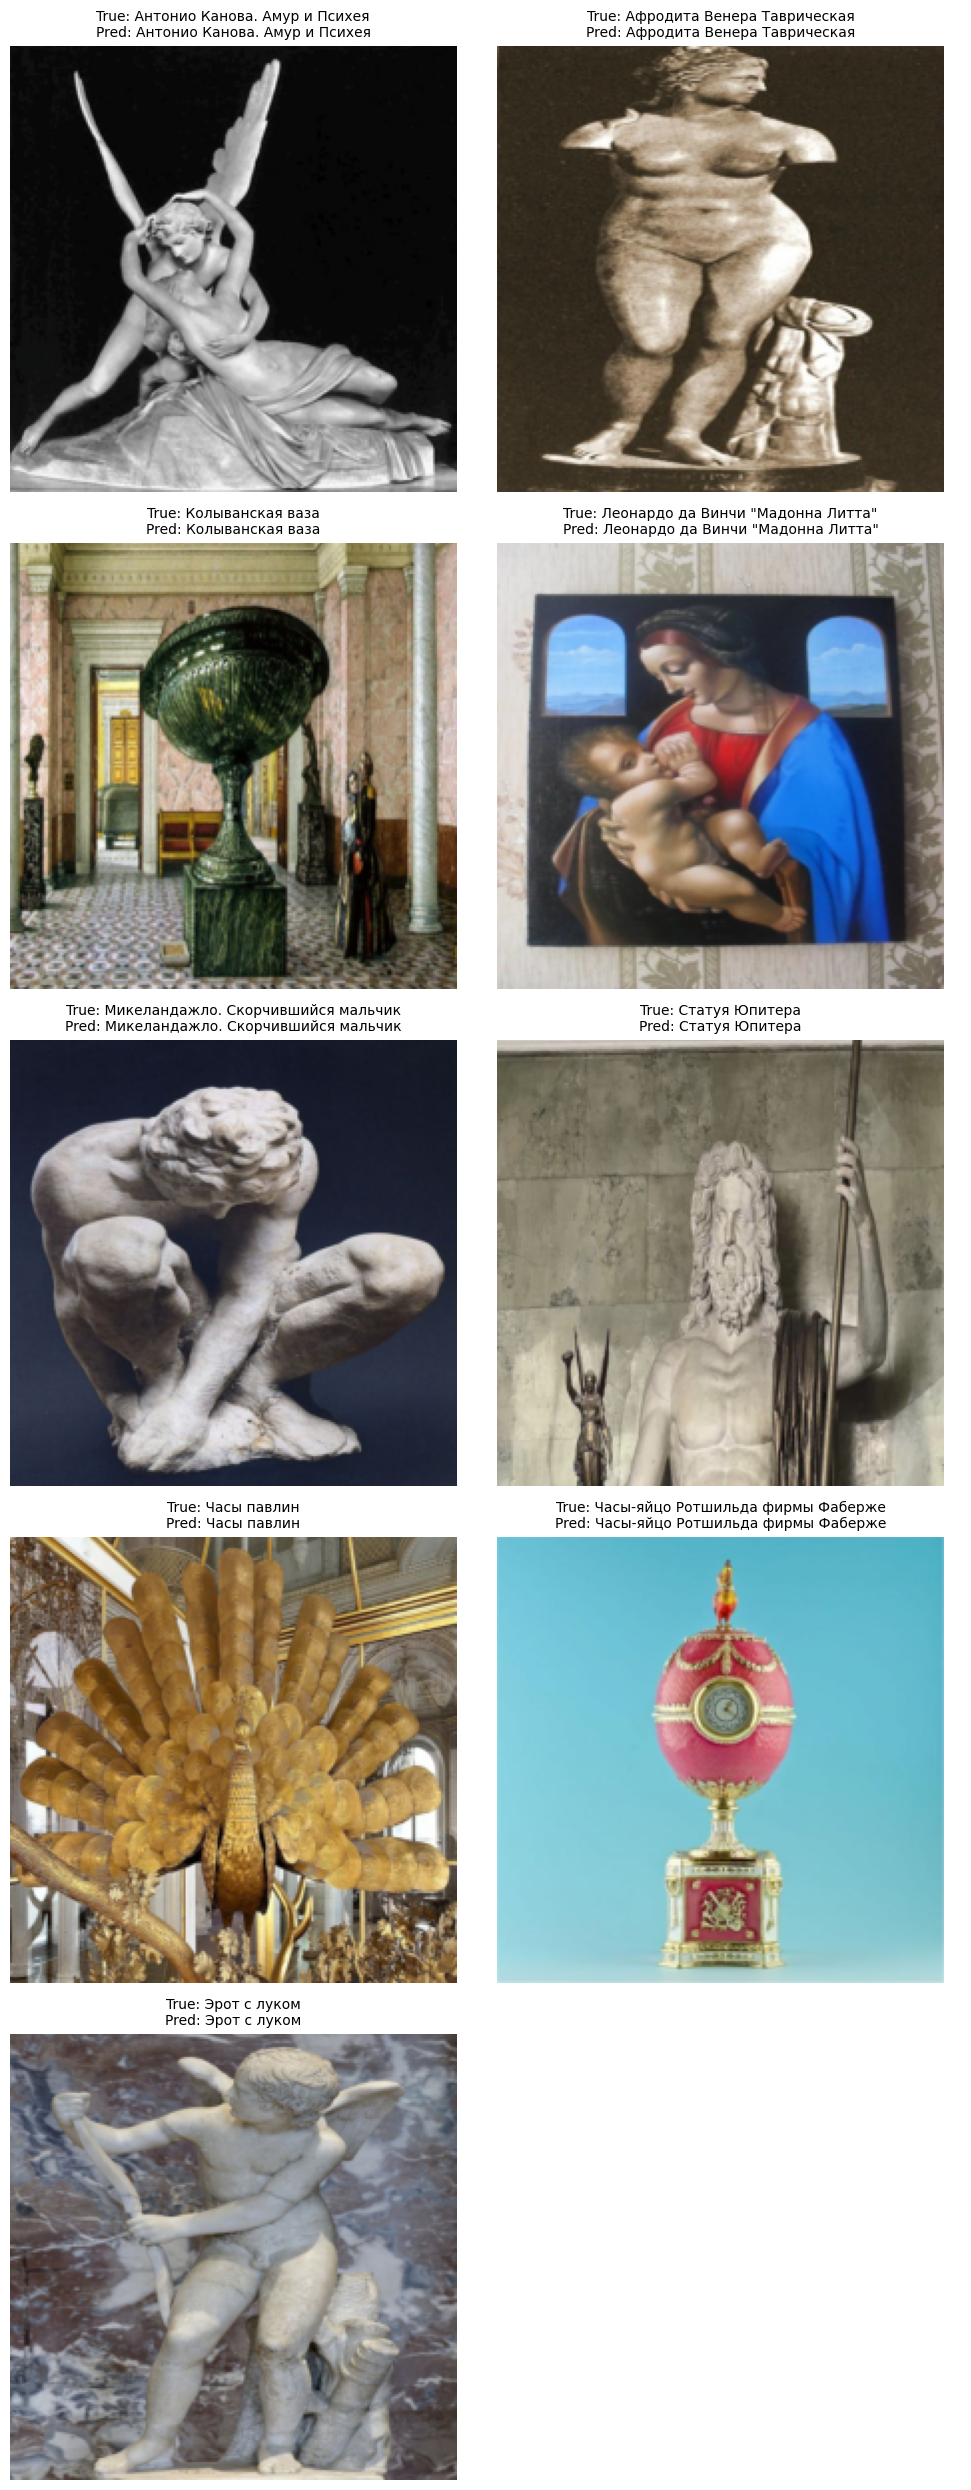

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Денормализация изображений:
# Изображения нормализованы для обучения модели, но для визуализации их нужно денормализовать.
# Мы используем средние значения и стандартные отклонения, которые использовались при нормализации.
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))  # Переводим из (C, H, W) в (H, W, C)
    image = std * image + mean  # Денормализация
    image = np.clip(image, 0, 1)  # Ограничиваем значения до [0, 1]
    return image

# Загрузка изображений:
# Изображения загружаются и преобразуются так же, как и при обучении.
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Добавляем batch dimension
    return image

# Для каждого изображения отображается:
# Само изображение.
# Истинный класс (True Label).
# Предсказанный класс (Predicted Label).
# Функция для визуализации изображений с предсказаниями
def visualize_predictions(model, test_loader, class_names, num_images=5):
    model.eval()  # Переключение модели в режим оценки
    images, labels = next(iter(test_loader))  # Получаем batch изображений
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Вычисляем количество строк и столбцов
    num_rows = (num_images + 1) // 2  # Максимум 2 изображения в строку
    num_cols = min(num_images, 2)    # Не больше 2 столбцов

    # Визуализация
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    if num_images == 1:
        axes = np.array([axes])  # Чтобы axes был массивом, даже если num_images = 1

    axes = axes.ravel()  # Преобразуем axes в одномерный массив для удобства

    for i in range(num_images):
        ax = axes[i]
        image = images[i].cpu()  # Перемещаем изображение на CPU
        image = denormalize(image)  # Денормализация

        ax.imshow(image)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}", fontsize=10)
        ax.axis('off')  # Скрываем оси

    # Скрываем пустые subplots, если количество изображений не кратно 2
    for j in range(num_images, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()  # Улучшаем расположение subplots
    plt.show()


# Пример использования
class_names = test_dataset.classes  # Список названий классов
visualize_predictions(model, test_loader, class_names, num_images=9)